## Hyperparameters

In [1]:
# image size to downsample to
downsampled_size = 16

batch_size = 128

# margin for triplet loss function
margin = 1.

n_epochs = 20
# log every x batches
log_interval = 20

# Convnet hyperparameters
lr = 1e-3
input_depth = 3
layer1_stride = 4
layer1_kernel_size = 8
layer1_output_channels = 64
layer1_padding = 0

visualize_filter = True

# Number of examples to visualize and see how the network embeds
visualize_model_working = 0

## Dataset setup

In [2]:
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms
import utils
from datasets import DownsampledCIFAR100


train_dataset = CIFAR100('./data/CIFAR100', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                             ]))
test_dataset = CIFAR100('./data/CIFAR100', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                            ]))

downsampled_train_dataset = DownsampledCIFAR100(train_dataset, downsampled_size=downsampled_size)
downsampled_test_dataset = DownsampledCIFAR100(test_dataset, downsampled_size=downsampled_size)

cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(downsampled_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(downsampled_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


## ConvNet setup

In [3]:
from torch.optim import lr_scheduler
import torch.optim as optim
from trainer import fit
from networks import EmbeddingNet, TripletNet, OnlineTripletNet
from losses import TripletLoss, OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, \
    RandomNegativeTripletSelector, SemihardNegativeTripletSelector

embedding_net = EmbeddingNet(input_depth=input_depth,
                             layer1_stride=layer1_stride,
                             layer1_kernel_size=layer1_kernel_size,
                             layer1_output_channels=layer1_output_channels,
                             layer1_padding=layer1_padding)
model = OnlineTripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))
optimizer = optim.Adam(model.parameters(), lr=lr)

# learning rate decay over epochs
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

## Train and test model

In [ ]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, visualize_workings=visualize_model_working)

Train: [0/50000 (0%)]	Loss: 0.503698
Train: [2560/50000 (5%)]	Loss: 0.485410
Train: [5120/50000 (10%)]	Loss: 0.468517
Train: [7680/50000 (15%)]	Loss: 0.474661
Train: [10240/50000 (20%)]	Loss: 0.464332
Train: [12800/50000 (26%)]	Loss: 0.469319
Train: [15360/50000 (31%)]	Loss: 0.473326
Train: [17920/50000 (36%)]	Loss: 0.467603
Train: [20480/50000 (41%)]	Loss: 0.464286
Train: [23040/50000 (46%)]	Loss: 0.473297
Train: [25600/50000 (51%)]	Loss: 0.464803
Train: [28160/50000 (56%)]	Loss: 0.472575
Train: [30720/50000 (61%)]	Loss: 0.460383
Train: [33280/50000 (66%)]	Loss: 0.470095
Train: [35840/50000 (72%)]	Loss: 0.465170
Train: [38400/50000 (77%)]	Loss: 0.478435
Train: [40960/50000 (82%)]	Loss: 0.469654
Train: [43520/50000 (87%)]	Loss: 0.474496
Train: [46080/50000 (92%)]	Loss: 0.478573
Train: [48640/50000 (97%)]	Loss: 0.467191
early stop
Epoch: 1/20. Train set: Average loss: 0.4702
Epoch: 1/20. Validation set: Average loss: 0.2407
Train: [0/50000 (0%)]	Loss: 0.458090
Train: [2560/50000 (5%)]	L

## Visualize filters

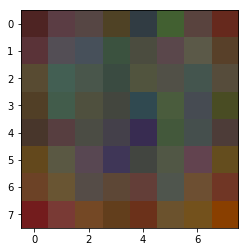

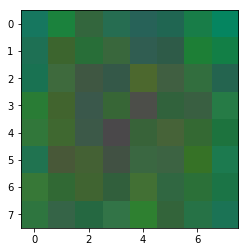

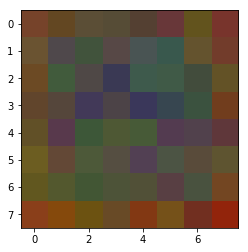

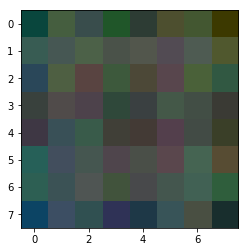

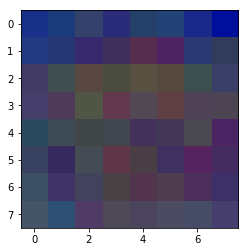

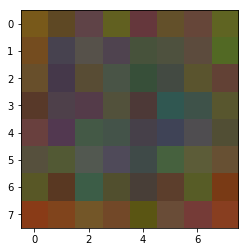

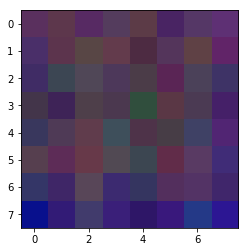

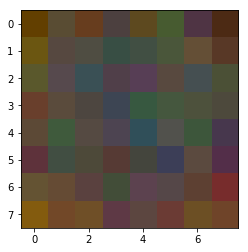

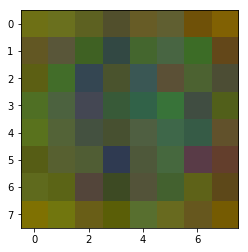

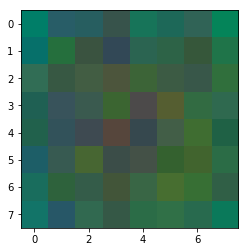

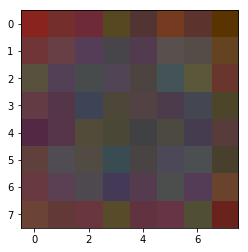

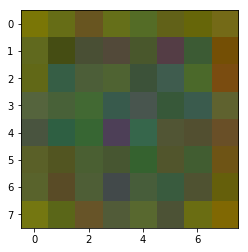

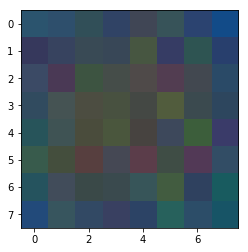

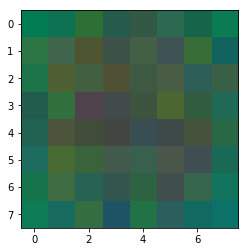

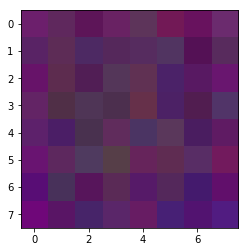

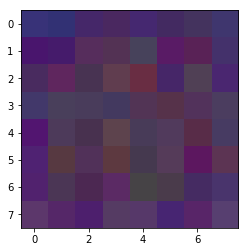

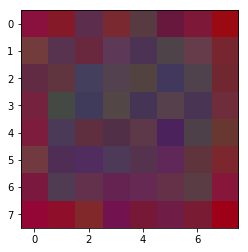

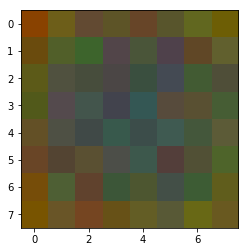

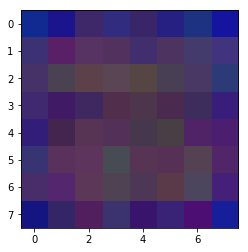

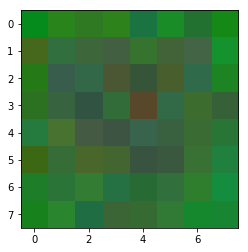

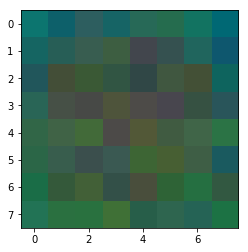

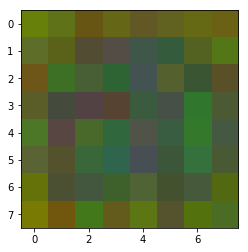

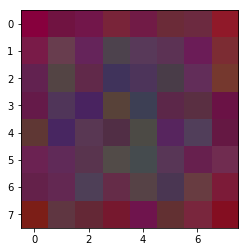

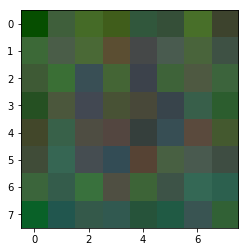

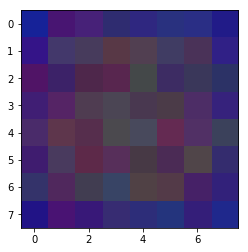

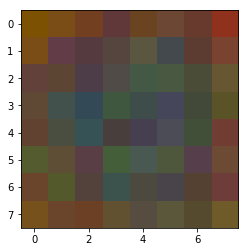

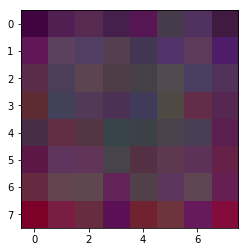

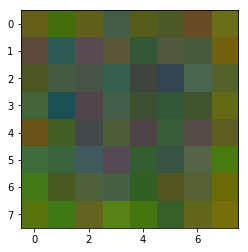

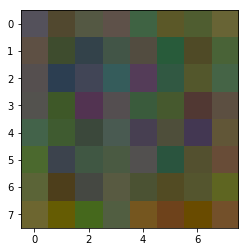

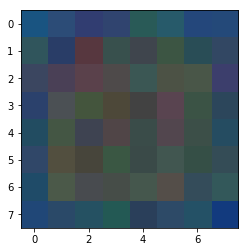

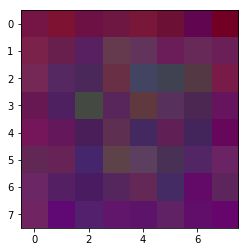

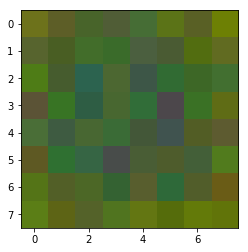

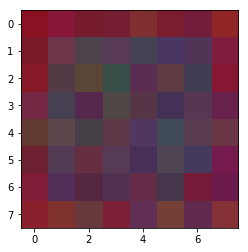

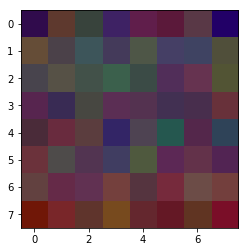

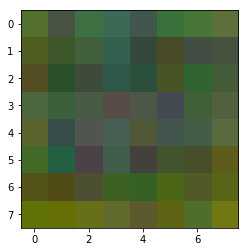

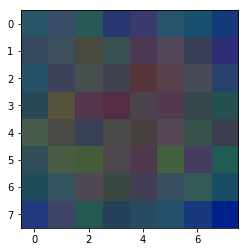

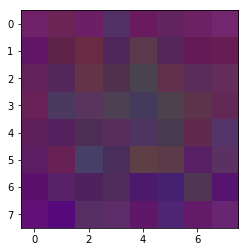

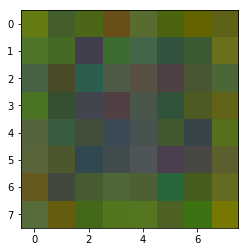

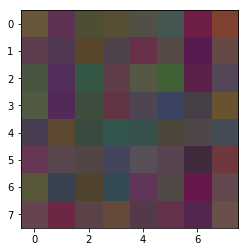

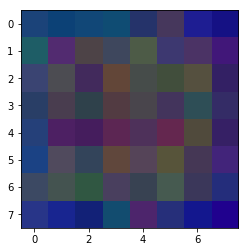

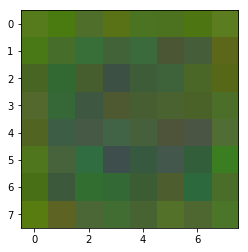

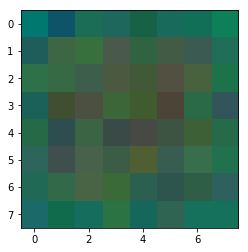

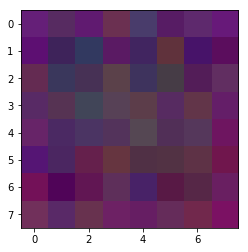

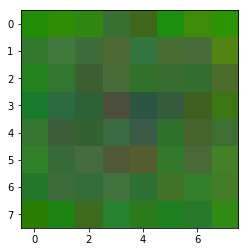

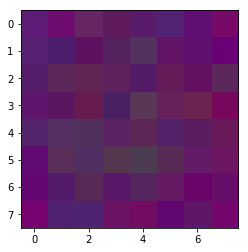

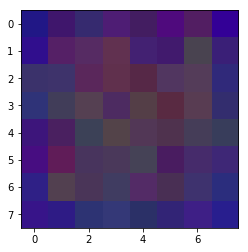

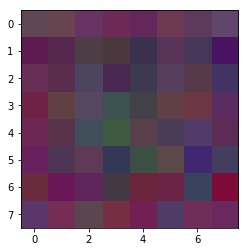

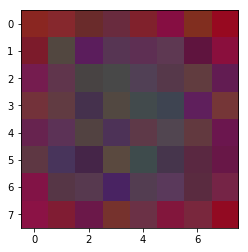

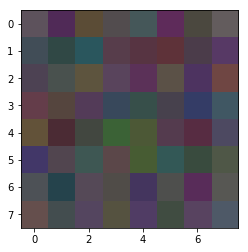

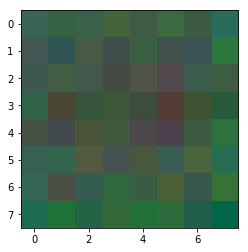

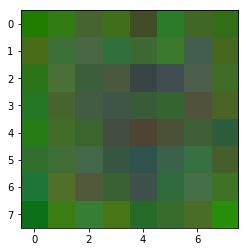

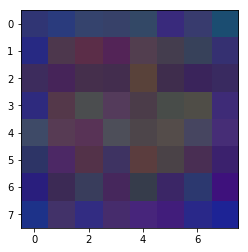

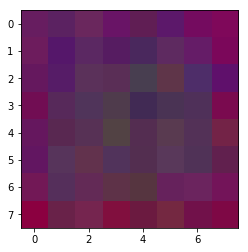

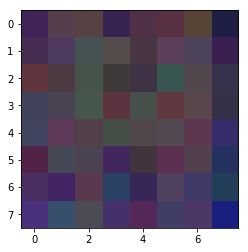

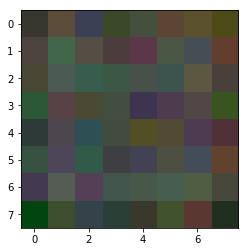

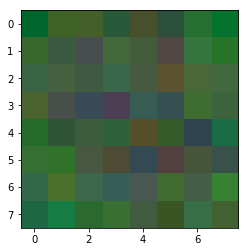

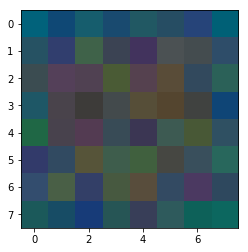

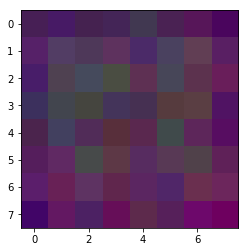

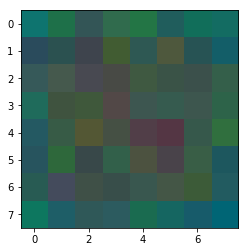

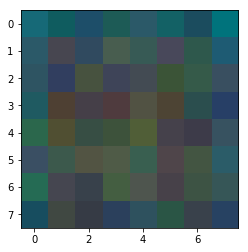

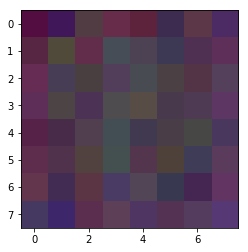

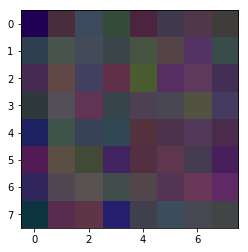

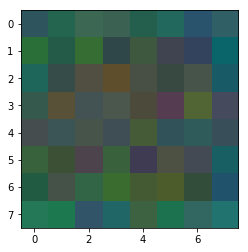

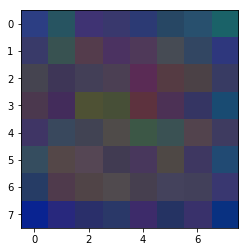

In [18]:
if visualize_filter:
    for filter in list(model.embedding_net.convnet.parameters())[0]:
        filter = utils.normalize_01(filter)
        utils.visualize_image(filter.detach().numpy())